In [1]:
import datetime
start_time = datetime.datetime.now()

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import time

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#參數設定(可修改)
#RIS參數設定
RIS_num = 40 #RIS單軸單元數量  目前測試最大88*88  mask版本為86*86
RIS_freq = 28e9 #頻率
RIS_incTH_deg = 30 #入射角
RIS_Feedhorn_Distance = 1000 #RIS和Feedhorn距離

#設定反射角&3dB波束寬&是否為multiBeam(存檔名用)
RIS_ref_deg = 30 #反射角
RIS_beamWidth = 10 #3dB波束寬
Is_multibeam = False #是否為multiBeam True or False


#訓練設定
Is_EarlyStop = False #是否開啟當loss低於門檻就停止訓練功能 True or False
threshold_value = 0.01 #早停loss門檻值
train_epochs = 5000 #設定最大訓練次數
save_loss = 20 #當loss低於此數值才會開始儲存(提速用)
SideLobeGain = -20 #設定旁波瓣增益

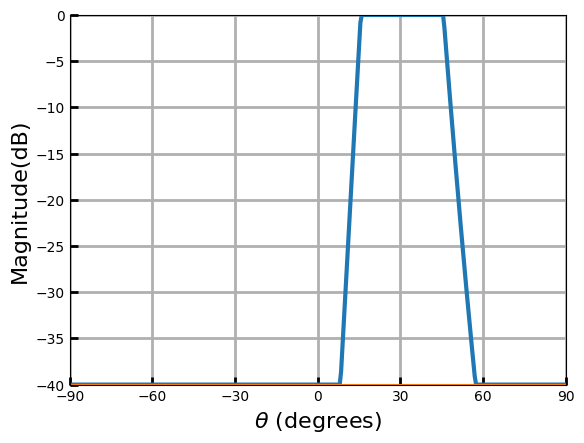

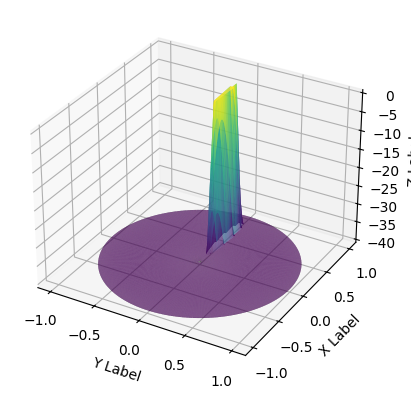

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 定義網格
theta = np.deg2rad(np.arange(-90, 90.1, 0.5))
phi = np.deg2rad(np.arange(0, 361, 2))

THETA, PHI = np.meshgrid(theta, phi)
u = np.sin(THETA) * np.cos(PHI)
v = np.sin(THETA) * np.sin(PHI)

# 橢圓的半徑
a_base = 20 * np.pi / 180
b_base = 2.5 * np.pi / 180
a_top = 12.75 * np.pi / 180
b_top = 1 * np.pi / 180

# 橢圓錐體中心的角度
phi_center = 0
theta_center = 29.5

# 角度轉換為弧度
phi_center_rad = np.deg2rad(phi_center)
theta_center_rad = np.deg2rad(theta_center)

# 計算中心位置
u_center = np.sin(theta_center_rad) * np.cos(phi_center_rad)
v_center = np.sin(theta_center_rad) * np.sin(phi_center_rad)

# 計算橢圓方程的r值
r_base = np.sqrt(((u - u_center) / a_base) ** 2 + ((v - v_center) / b_base) ** 2)
r_top = np.sqrt(((u - u_center) / a_top) ** 2 + ((v - v_center) / b_top) ** 2)

# 初始化高度矩陣
SideLobeGain = -40  # 假設這裡設置了 SideLobeGain
test = SideLobeGain * np.ones(u.shape)

# 計算內部高度
inside_cone = (r_base <= 1) & (r_top > 1)
scale = np.minimum(1, (1 - r_base[inside_cone]) / (1 - (a_top / a_base)))

test[inside_cone] = SideLobeGain + (-SideLobeGain) * scale

# 頂部橢圓內的點高度設為0
test[r_top <= 1] = 0

# 繪製俯視圖
plt.figure()
plt.plot(np.arange(-90, 90.1, 0.5), test[0], linewidth=3)
plt.plot(np.arange(-90, 90.1, 0.5), test[46])
plt.grid(True, which='both', linewidth=2)
plt.xlim([-90, 90])
plt.ylim([-40, 0])
plt.xticks(np.arange(-90, 91, 30))
plt.xlabel(r'$\theta$ (degrees)', fontsize=16)
plt.ylabel('Magnitude(dB)', fontsize=16)
plt.gca().tick_params(axis='both', which='both', direction='in', width=2, length=6)

# 繪製三維圖
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 轉換成笛卡爾坐標
x = np.sin(THETA) * np.cos(PHI)
y = np.sin(THETA) * np.sin(PHI)
z = test

ax.plot_trisurf(y.flatten(), x.flatten(), z.flatten(), cmap='viridis')
ax.set_xlabel('Y Label')
ax.set_ylabel('X Label')
ax.set_zlabel('Z Label')

plt.show()
test_tensor = torch.tensor(test, dtype=torch.float32)
test_tensor = test_tensor.view(-1, 181, 361)

In [11]:
#固定參數(勿動)

from numpy import sin, cos, pi, array, deg2rad, rad2deg
from numpy.linalg import norm
from tqdm import tqdm
import os
import pandas as pd
    
c = 3e8  # 光速
lamda = c / RIS_freq
R = RIS_Feedhorn_Distance
incPH_deg , refPH_deg = 90 , 0
de = 0.5 * c / RIS_freq 
k = 2 * pi / (c / RIS_freq) #角波束
M = np.arange(1,RIS_num+1)
N = np.arange(1,RIS_num+1)


theDeg = [i for i in np.arange(-90,90.1,0.5)]
phiDeg = [i for i in range(0,361,2)]

theta = deg2rad(theDeg)
phi   = deg2rad(phiDeg)

[THETA, PHI]=np.meshgrid(theta,phi)
THETA = np.round_(THETA , decimals = 4)
PHI = np.round_(PHI , decimals = 4)
u = np.round_(((sin(THETA)) * (cos(PHI))) , decimals = 4)
v = np.round_(((sin(THETA)) * (sin(PHI))) , decimals = 4)

incTH_rad, incPH_rad = deg2rad([RIS_incTH_deg, incPH_deg])

low_bound_X = -(RIS_num / 2 - 0.5)
high_bound_X = low_bound_X + RIS_num

low_bound_Y = -(RIS_num / 2 - 0.5)
high_bound_Y = low_bound_Y + RIS_num
x, y = np.mgrid[low_bound_Y:high_bound_Y, low_bound_X:high_bound_X]

feed_x = R * sin(incTH_rad) * cos(incPH_rad)
feed_y = R * sin(incTH_rad) * sin(incPH_rad)
feed_z = R * cos(incTH_rad)

det_x = feed_x - x * de
det_y = feed_y - y * de
det_z = feed_z

Ri = np.sqrt(det_x ** 2 + det_y ** 2 + det_z ** 2)

incPD = k * Ri

mm = M - (RIS_num+1)/2
nn = N - (RIS_num+1)/2
[m,n]=np.meshgrid(mm,nn)

m = np.reshape(m,(1,1,-1))
n = np.reshape(n,(1,1,-1))

In [3]:
import os
import numpy as np
import csv

def read_csv_to_matrix(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        matrix = []
        for row in reader:
            matrix.append([int(x) for x in row])
        return np.array(matrix)

def phase_transfer(MPD):
    return MPD.flatten()

def convert_to_decimal_string(phase_arr):
    count = 0
    MPDBinaryString = ""
    ArduinoCode = ""
    
    for i in range(len(phase_arr)):
        MPDBinaryString += str(phase_arr[i])
        count += 1
        if count % 8 == 0 and count != 0:
            ArduinoCode += f"0x{int(MPDBinaryString, 2):02X},"
            MPDBinaryString = ""
    return ArduinoCode
def process_folder(folder_path, output_file_path):
    with open(output_file_path, 'w') as output_file:
        # 遍歷資料夾內所有的CSV文件
        for filename in os.listdir(folder_path):
            if filename.endswith(".csv"):
                file_path = os.path.join(folder_path, filename)
                # 讀取CSV並處理
                matrix = read_csv_to_matrix(file_path)
                phase_arr = phase_transfer(matrix)
                converted_string = convert_to_decimal_string(phase_arr)
                # 將文件名加入轉換結果前
                file_label = filename.replace(".csv", "")
                output_file.write(f"{file_label}: {converted_string}\n")

# 指定CSV檔案所在資料夾的路徑
folder_path = '32X64'

# 指定輸出TXT檔案的路徑
output_file_path = '32X64_output.txt'

# 處理資料夾內所有CSV檔案並將結果保存到TXT文件
process_folder(folder_path, output_file_path)

print(f"All results have been saved to {output_file_path}")


All results have been saved to 32X64_output.txt
